In [17]:
import numpy as np
import pandas as pd
import plotly.graph_objs as go

In [18]:
# ====== Load data from csv ======
df_raw = pd.read_excel("JunLiang CAP02_Segmented.xlsx", sheet_name="Gait marker", header=2, engine="openpyxl")

In [19]:
# ====== 2. Extract markers  ======
def extract_triplet(df, marker_token):
    idx = None
    for i, c in enumerate(df.columns):
        if isinstance(c, str) and marker_token.lower() in c.lower():
            idx = i
            break
    if idx is None:
        return None
    triplet_cols = df.columns[idx:idx+3]
    sub = df.loc[:, triplet_cols].copy()
    for c in triplet_cols:
        sub[c] = pd.to_numeric(sub[c], errors="coerce")
    sub = sub.dropna(how="any")
    arr = sub.to_numpy(dtype=float)
    if arr.shape[1] != 3:
        return None
    return arr

markers_to_extract = {
    "Shin1": "KNEE MODEL:SHIN1",
    "Shin2": "KNEE MODEL:SHIN2",
    "Shin3": "KNEE MODEL:SHIN3",
    "Thigh1": "KNEE MODEL:THIGH1",
    "Thigh2": "KNEE MODEL:THIGH2",
    "Thigh3": "KNEE MODEL:THIGH3",
}

data = {}
for key, token in markers_to_extract.items():
    arr = extract_triplet(df_raw, token)
    if arr is None:
        print(f"❌ Could not parse triplet for {key} (token: {token})")
    else:
        data[key] = arr
        print(f"Parsed {key}: shape {arr.shape}")

N = min(arr.shape[0] for arr in data.values())
for k in data:
    data[k] = data[k][:N, :]


Parsed Shin1: shape (2276, 3)
Parsed Shin2: shape (2276, 3)
Parsed Shin3: shape (2276, 3)
Parsed Thigh1: shape (2276, 3)
Parsed Thigh2: shape (2276, 3)
Parsed Thigh3: shape (2276, 3)


In [20]:
# ====== 3. Compute frame and coordinates  ======
def normalize_rows(v):
    n = np.linalg.norm(v, axis=1, keepdims=True)
    n[n < 1e-12] = 1.0
    return v / n

def build_frame(p1, p2, p3):
    x = normalize_rows(p2 - p1)
    z = normalize_rows(np.cross(x, p3 - p1))
    y = normalize_rows(np.cross(z, x))
    R = np.stack([x, y, z], axis=2)
    O = p1
    return R, O

def sphere_fit(points):
    P = points
    b = np.sum(P * P, axis=1).reshape(-1, 1)
    A = np.hstack([2 * P, np.ones((P.shape[0], 1))])
    x, *_ = np.linalg.lstsq(A, b, rcond=None)
    c = x[:3, 0]
    r = float(np.sqrt(np.mean(np.sum((P - c) ** 2, axis=1))))
    return c, r

R_shin,  O_shin  = build_frame(data["Shin1"],  data["Shin2"],  data["Shin3"])
R_thigh, O_thigh = build_frame(data["Thigh1"], data["Thigh2"], data["Thigh3"])

In [21]:
# ====== SPHERE FIT (COR) This one ======
thigh_cloud = np.vstack([data["Thigh1"], data["Thigh2"], data["Thigh3"]])
center, r = sphere_fit(thigh_cloud)
frame = N // 2
shinOrigin  = O_shin[frame]
thighOrigin = O_thigh[frame]
Rsh = R_shin[frame]
Rth = R_thigh[frame]

deltaShin  = center - shinOrigin
deltaThigh = center - thighOrigin
distanceShinCOR  = float(np.linalg.norm(deltaShin))
distanceThighCOR = float(np.linalg.norm(deltaThigh))
center_in_shin  = Rsh.T @ (center - shinOrigin)
center_in_thigh = Rth.T @ (center - thighOrigin)

In [22]:
# ====== 5. PRINT SUMMARY ======
print("=== Numeric Summary (parsed triplets) ===")
print(f"Frames used: {N}")
print(f"Sphere-fit COR center (lab): {center}")
print(f"Sphere-fit radius (mm): {r:.3f}")
print(f"Distance (Thigh origin → COR): {distanceThighCOR:.3f} mm")
print(f"Distance (Shin origin  → COR): {distanceShinCOR:.3f} mm")
print(f"Δ (Thigh → COR) [X,Y,Z] (mm): {deltaThigh}")
print(f"Δ (Shin  → COR) [X,Y,Z] (mm): {deltaShin}")
print(f"COR in Thigh local frame (mm): {center_in_thigh}")
print(f"COR in Shin  local frame (mm): {center_in_shin}")

=== Numeric Summary (parsed triplets) ===
Frames used: 2276
Sphere-fit COR center (lab): [ -8.32554887 394.44608661  34.37346444]
Sphere-fit radius (mm): 24.018
Distance (Thigh origin → COR): 24.001 mm
Distance (Shin origin  → COR): 303.086 mm
Δ (Thigh → COR) [X,Y,Z] (mm): [-23.22564887  -5.97791339   0.93596444]
Δ (Shin  → COR) [X,Y,Z] (mm): [   3.38935113   -6.11691339 -303.00553556]
COR in Thigh local frame (mm): [23.13281215 -4.12230889 -4.89099322]
COR in Shin  local frame (mm): [213.29185704 212.72409942  33.41107836]


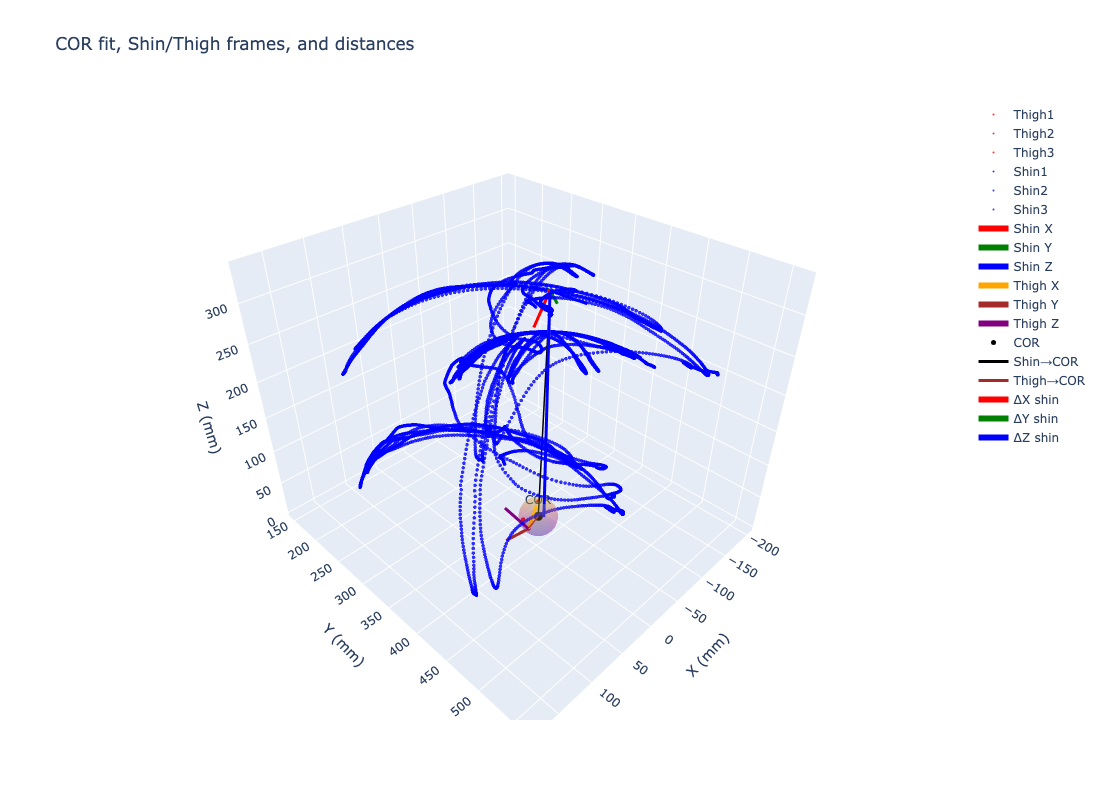

In [42]:
# ====== 6. 3D VISUALIZATION ======
def trace_points(name, pts, color, size=3):
    return go.Scatter3d(
        x=pts[:,0], y=pts[:,1], z=pts[:,2],
        mode='markers', marker=dict(size=size, color=color),
        name=name, opacity=0.8
    )

def trace_arrow(name, origin, vec, color, width=6):
    p2 = origin + vec
    return go.Scatter3d(
        x=[origin[0], p2[0]],
        y=[origin[1], p2[1]],
        z=[origin[2], p2[2]],
        mode='lines', line=dict(width=width, color=color),
        name=name
    )

def sphere_surface(center, radius, res=24):
    u = np.linspace(0, 2*np.pi, res)
    v = np.linspace(0, np.pi, res)
    x = center[0] + radius * np.outer(np.cos(u), np.sin(v))
    y = center[1] + radius * np.outer(np.sin(u), np.sin(v))
    z = center[2] + radius * np.outer(np.ones_like(u), np.cos(v))
    return go.Surface(x=x, y=y, z=z, opacity=0.25, showscale=False, name='COR sphere')

traces = []
# Markers
traces += [trace_points("Thigh1", data["Thigh1"], "red", size=2)]
traces += [trace_points("Thigh2", data["Thigh2"], "red", size=2)]
traces += [trace_points("Thigh3", data["Thigh3"], "red", size=2)]
traces += [trace_points("Shin1",  data["Shin1"],  "blue", size=2)]
traces += [trace_points("Shin2",  data["Shin2"],  "blue", size=2)]
traces += [trace_points("Shin3",  data["Shin3"],  "blue", size=2)]

scale = 40.0
# Shin and Thigh triads
traces += [
    trace_arrow("Shin X",  shinOrigin,  scale * Rsh[:,0], "red"),
    trace_arrow("Shin Y",  shinOrigin,  scale * Rsh[:,1], "green"),
    trace_arrow("Shin Z",  shinOrigin,  scale * Rsh[:,2], "blue"),
    trace_arrow("Thigh X", thighOrigin, scale * Rth[:,0], "orange"),
    trace_arrow("Thigh Y", thighOrigin, scale * Rth[:,1], "brown"),
    trace_arrow("Thigh Z", thighOrigin, scale * Rth[:,2], "purple"),
]

# COR and sphere
traces += [go.Scatter3d(x=[center[0]], y=[center[1]], z=[center[2]],
                        mode='markers+text',
                        marker=dict(size=5, color='black'),
                        text=["COR"],
                        textposition="top center",
                        name="COR")]
traces += [sphere_surface(center, r)]

# Connecting lines and per-axis components (Shin)
traces += [
    trace_arrow("Shin→COR",  shinOrigin,  center - shinOrigin,  "black", width=3),
    trace_arrow("Thigh→COR", thighOrigin, center - thighOrigin, "brown", width=3),
    trace_arrow("ΔX shin", shinOrigin, np.array([deltaShin[0], 0, 0]), "red"),
    trace_arrow("ΔY shin", shinOrigin, np.array([0, deltaShin[1], 0]), "green"),
    trace_arrow("ΔZ shin", shinOrigin, np.array([0, 0, deltaShin[2]]), "blue"),
]

layout = go.Layout(
    scene=dict(
        xaxis_title="X (mm)", yaxis_title="Y (mm)", zaxis_title="Z (mm)",
        aspectmode='data'
    ),
    title="COR fit, Shin/Thigh frames, and distances",
    showlegend=True, height=800
)

fig = go.Figure(data=traces, layout=layout)
fig.show()
